<a href="https://colab.research.google.com/github/prasanth5reddy/D2L/blob/master/Computer%20Vision/image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
w_dir = '/content/drive/My Drive/Colab/D2L.AI/'
sys.path.append(w_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing Libraries

In [2]:
!pip uninstall mxnet && pip install mxnet-cu100

Importing Libraries

In [0]:
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import d2l
import sys
import time
%matplotlib inline

Common Image Augmentation Method

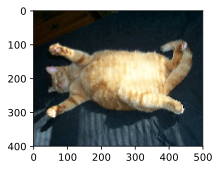

In [4]:
d2l.set_figsize()
img = image.imread(w_dir + 'img/cat1.jpg')
d2l.plt.imshow(img.asnumpy())

In [0]:
def show_images(imgs, num_rows, num_cols, scale=2):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  for i in range(num_rows):
    for j in range(num_cols):
      axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
      axes[i][j].axes.get_xaxis().set_visible(False)
      axes[i][j].axes.get_yaxis().set_visible(False)
  
  return axes

In [0]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  show_images(Y, num_rows, num_cols, scale)

Flip and Crop

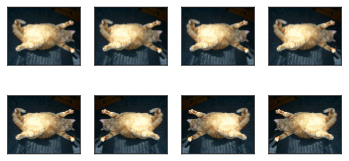

In [7]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

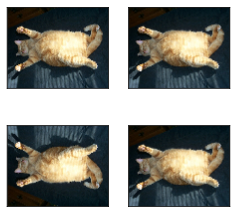

In [8]:
apply(img, gdata.vision.transforms.RandomFlipTopBottom(), num_cols=2, num_rows=2, scale=2)

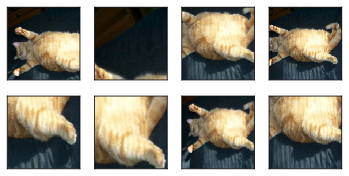

In [9]:
shape_aug = gdata.vision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

Change Color

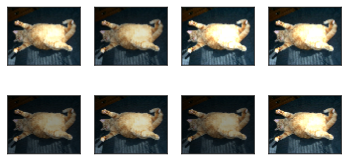

In [10]:
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

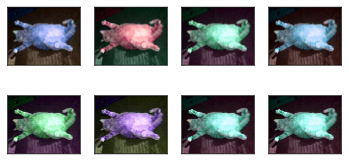

In [11]:
apply(img, gdata.vision.transforms.RandomHue(0.5))

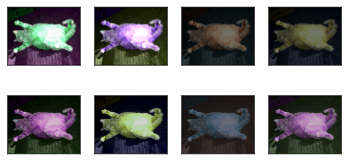

In [12]:
color_aug = gdata.vision.transforms.RandomColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

Overlaying Multiple Image Augmentation Methods

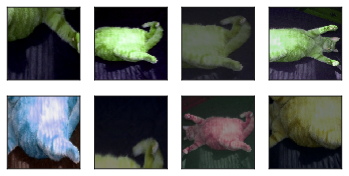

In [13]:
augs = gdata.vision.transforms.Compose([gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

Using an Image Augmentation Training Model

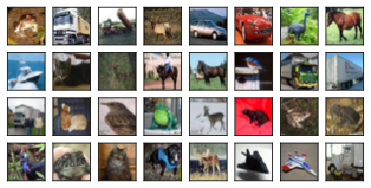

In [14]:
show_images(gdata.vision.CIFAR10(train=True)[:32][0], 4, 8, scale=0.8)
d2l.plt.show()

In [0]:
train_augs = gdata.vision.transforms.Compose([gdata.vision.transforms.RandomFlipLeftRight(), gdata.vision.transforms.ToTensor()])

test_augs = gdata.vision.transforms.Compose([gdata.vision.transforms.ToTensor()])

In [0]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size):
  return gdata.DataLoader(gdata.vision.CIFAR10(train=is_train).transform_first(augs),
                          batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

Multi-GPU Training Model

In [0]:
def try_all_gpus():
  ctxes = []
  try:
    for i in range(4):
      ctx = mx.gpu(i)
      _ = nd.array([0], ctx=ctx)
      ctxes.append(ctx)
  except mx.base.MXNetError:
    pass
  if not ctxes:
    ctxes = [mx.cpu()]
  return ctxes

In [0]:
def _get_batch(batch, ctx):
  features, labels = batch
  if labels.dtype != features.dtype:
    labels = labels.astype(features.dtype)
  return (gutils.split_and_load(features, ctx), gutils.split_and_load(labels, ctx), features.shape[0])

In [0]:
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
  if isinstance(ctx, mx.Context):
    ctx = [ctx]
  acc_sum, n = nd.array([0]), 0
  for batch in data_iter:
    features, labels, _ = _get_batch(batch, ctx)
    for X, y in zip(features, labels):
      y = y.astype('float32')
      acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
      n += y.size
    acc_sum.wait_to_read()
  return acc_sum.asscalar() / n

In [0]:
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
  print('training on', ctx)
  if isinstance(ctx, mx.Context):
    ctx = [ctx]
    
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
    for i, batch in enumerate(train_iter):
      Xs, ys, batch_size = _get_batch(batch, ctx)
      ls = []
      with autograd.record():
        y_hats = [net(X) for X in Xs]
        ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
      for l in ls:
        l.backward()
      trainer.step(batch_size)
      train_l_sum += sum([l.sum().asscalar() for l in ls])
      n += sum([l.size for l in ls])
      train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar() for y_hat, y in zip(y_hats, ys)])
      m += sum([y.size for y in ys])
      
    test_acc = evaluate_accuracy(test_iter, net, ctx)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc, time.time() - start))

In [0]:
def train_without_data_aug(lr=0.001):
  batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
  net.initialize(ctx=ctx, init=init.Xavier())
  trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
  loss = gloss.SoftmaxCrossEntropyLoss()
  train_iter = load_cifar10(True, test_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

In [0]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
  batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
  net.initialize(ctx=ctx, init=init.Xavier())
  trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
  loss = gloss.SoftmaxCrossEntropyLoss()
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

In [23]:
train_without_data_aug()

training on [gpu(0)]
epoch 1, loss 1.4456, train acc 0.487, test acc 0.534, time 48.3 sec
epoch 2, loss 0.8688, train acc 0.691, test acc 0.692, time 44.7 sec
epoch 3, loss 0.6340, train acc 0.779, test acc 0.613, time 44.9 sec
epoch 4, loss 0.4771, train acc 0.833, test acc 0.639, time 44.9 sec
epoch 5, loss 0.3576, train acc 0.875, test acc 0.778, time 44.8 sec
epoch 6, loss 0.2616, train acc 0.908, test acc 0.773, time 44.7 sec
epoch 7, loss 0.1967, train acc 0.930, test acc 0.807, time 44.9 sec
epoch 8, loss 0.1364, train acc 0.952, test acc 0.799, time 44.9 sec
epoch 9, loss 0.1028, train acc 0.964, test acc 0.786, time 44.9 sec
epoch 10, loss 0.0823, train acc 0.971, test acc 0.796, time 45.0 sec


In [24]:
train_with_data_aug(train_augs, test_augs)

training on [gpu(0)]
epoch 1, loss 1.3519, train acc 0.523, test acc 0.572, time 45.5 sec
epoch 2, loss 0.7991, train acc 0.716, test acc 0.631, time 45.0 sec
epoch 3, loss 0.5950, train acc 0.791, test acc 0.775, time 44.9 sec
epoch 4, loss 0.4801, train acc 0.833, test acc 0.759, time 45.1 sec
epoch 5, loss 0.4009, train acc 0.859, test acc 0.780, time 45.0 sec
epoch 6, loss 0.3325, train acc 0.885, test acc 0.822, time 45.1 sec
epoch 7, loss 0.2743, train acc 0.905, test acc 0.827, time 45.1 sec
epoch 8, loss 0.2363, train acc 0.918, test acc 0.819, time 45.0 sec
epoch 9, loss 0.2025, train acc 0.931, test acc 0.819, time 45.2 sec
epoch 10, loss 0.1731, train acc 0.939, test acc 0.834, time 44.7 sec
